In [1]:
import cv2                         
import numpy as np                 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the source image
src_img = cv2.imread('uni.jpg')

In [3]:
def show_image(img, title, colorspace):
    dpi = 96
    figsize = (img.shape[1] / dpi, img.shape[0] / dpi)
    fig, ax = plt.subplots(figsize = figsize, dpi = dpi)
    if colorspace == 'RGB':
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation = 'spline16')
    if colorspace == 'gray':
        plt.imshow(img, cmap = 'gray')
    plt.title(title, fontsize = 12)
    ax.axis('off')
    plt.show() 

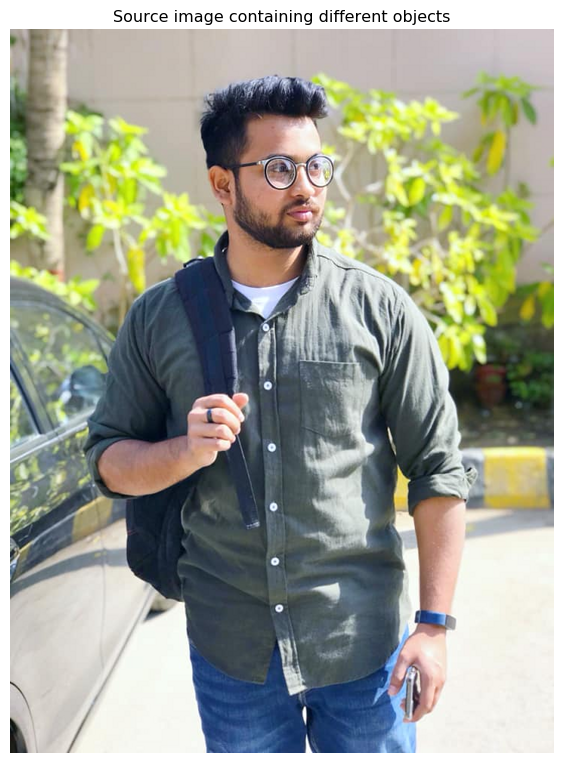

In [4]:
show_image(src_img, 'Source image containing different objects', 'RGB')

The yellow matchbox will be extracted from the above image and its extracted features will be used to recognize this matchbox in other images.

There are several approaches to extract an object and it highly depends on the given image. In this case, the matchbox can be uniquely identified by its color and consequently we will use color filtering to accomplish that task. HSV (Hue, Saturation, Value) is better suited than BGR (Blue, Green, Red) values to filter an image based on color.

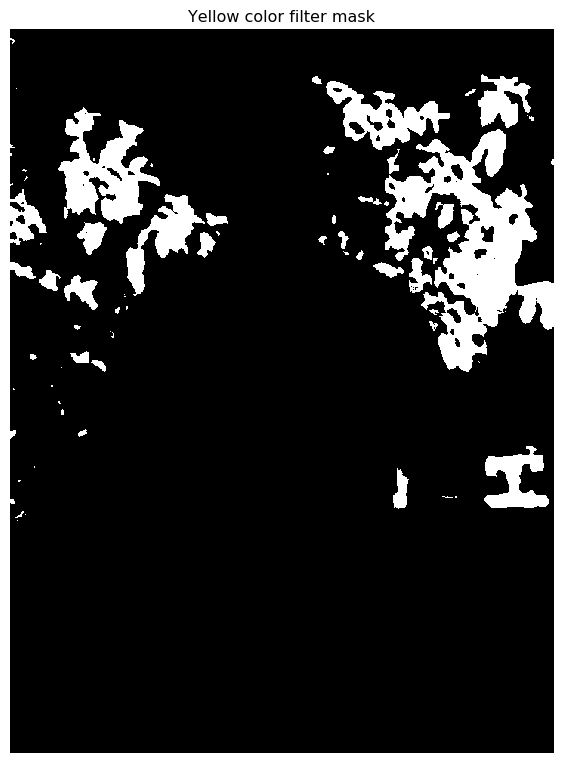

In [9]:
# Change colorspace from BGR to HSV
src_img_hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)

# Define limits of yellow HSV values
yellow_lower = np.array([16, 100, 100])
yellow_upper = np.array([45, 255, 255])

# Filter the image and get the mask
mask = cv2.inRange(src_img_hsv, yellow_lower, yellow_upper)

show_image(mask, 'Yellow color filter mask', 'gray')

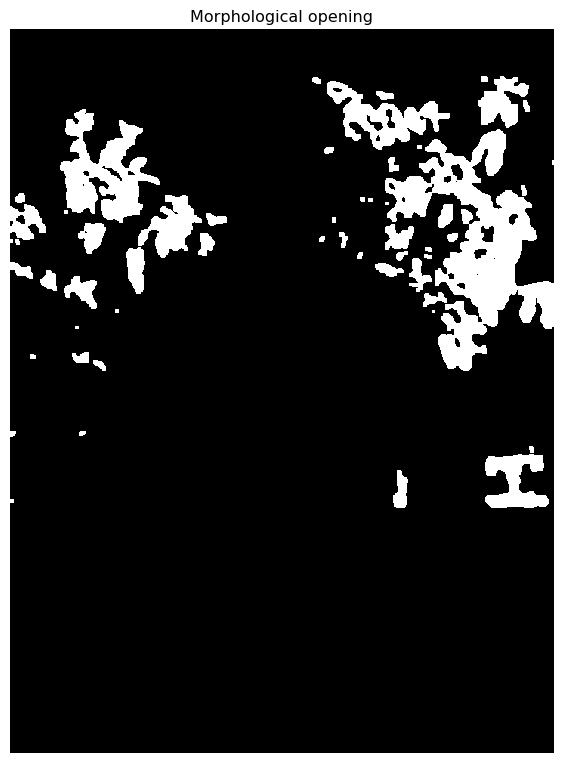

In [10]:
# Remove white noise
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

show_image(opening, 'Morphological opening', 'gray')

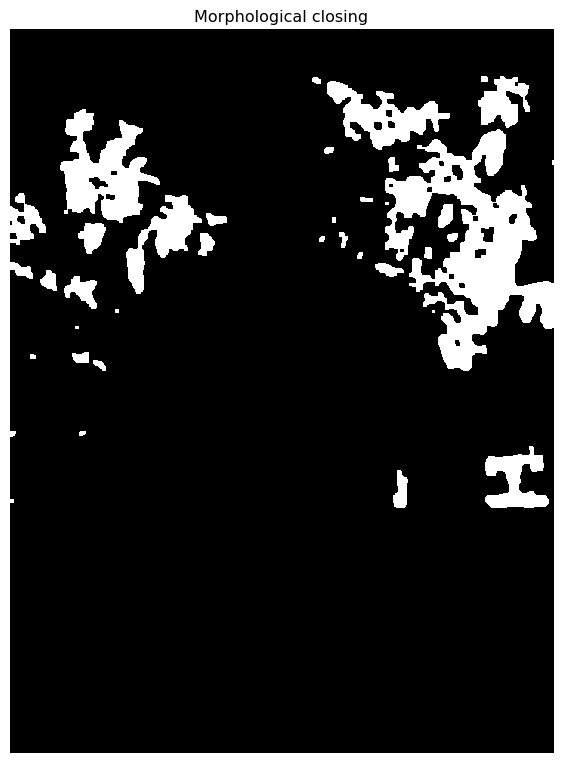

In [11]:
# Remove small black dots
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

show_image(closing, 'Morphological closing', 'gray')

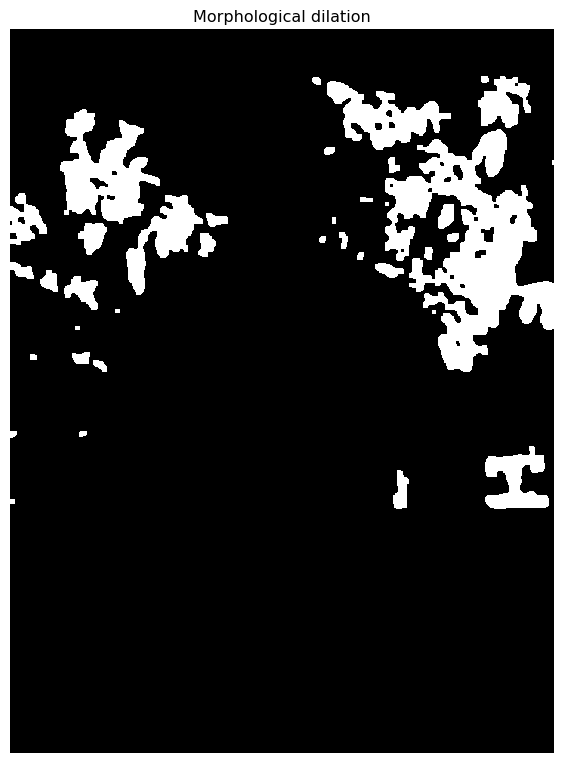

In [12]:
# Get back the fine boundary edges using dilation
kernel1 = np.ones((2, 2), np.uint8)
dilation = cv2.dilate(closing, kernel1, iterations = 1)

show_image(dilation, 'Morphological dilation', 'gray')

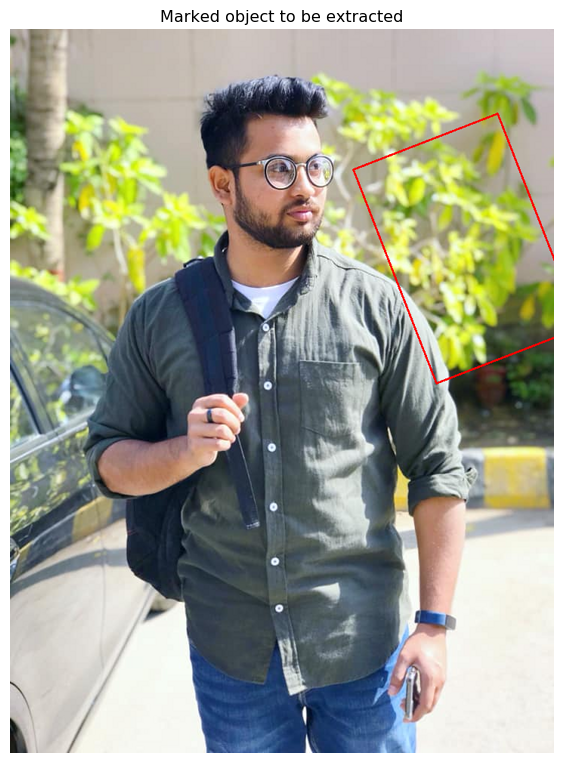

In [13]:
contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# There are 2 contours: outer one is the rectangle(ish) and inner one is the circle(ish)
# Get the outer contour (it has larger area than the inner contour)
c1 = max(contours, key = cv2.contourArea)

# Define the bounding rectangle around the contour
rect = cv2.minAreaRect(c1)

# Get the 4 corner coordinates of the rectangle
box = cv2.boxPoints(rect)
box = np.int0(box)

# Draw the bounding rectangle to show the marked object
temp_img = src_img.copy()
bdg_rect = cv2.drawContours(temp_img, [box], 0, (0, 0, 255), 2)

show_image(bdg_rect, 'Marked object to be extracted', 'RGB')

The matchbox is marked in red in the above image. It is extracted by applying geometric transformations on the image and the result is saved as the query image.

In [14]:
width = box[0][0] - box[1][0]
height = box[1][1] - box[2][1]

src_pts = box.astype('float32')
dst_pts = np.array([[width, height],
                    [0, height],
                    [0, 0],
                    [width, 0]], dtype = 'float32')

# Get the transformation matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Apply the perspective transformation
warped = cv2.warpPerspective(src_img, M, (width, height))

# Save it as the query image
query_img = warped

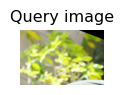

In [16]:
show_image(query_img, 'Query image', 'RGB')

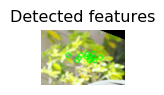

In [17]:
# Create an ORB object
orb = cv2.ORB_create()

# Detect and visualize the features
features = orb.detect(query_img, None)
f_img = cv2.drawKeypoints(query_img, features, None, color = (0, 255, 0), flags = 0)

show_image(f_img, 'Detected features', 'RGB')

In [19]:
# Function to match features and find the object
def match_feature_find_object(query_img, train_img, min_matches): 
    # Create an ORB object
    orb = cv2.ORB_create(nfeatures=100000)
    
    features1, des1 = orb.detectAndCompute(query_img, None)
    features2, des2 = orb.detectAndCompute(train_img, None)

    # Create Brute-Force matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k = 2)
    
    # Nearest neighbour ratio test to find good matches
    good = []    
    good_without_lists = []    
    matches = [match for match in matches if len(match) == 2] 
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
            good_without_lists.append(m)
    if len(good) >= min_matches:
        # Draw a polygon around the recognized object
        src_pts = np.float32([features1[m.queryIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
        dst_pts = np.float32([features2[m.trainIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
        
        # Get the transformation matrix
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
               
        # Find the perspective transformation to get the corresponding points
        h, w = query_img.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        
        train_img = cv2.polylines(train_img, [np.int32(dst)], True, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        print('Not enough good matches are found - {}/{}'.format(len(good), min_matches))
            
    result_img = cv2.drawMatchesKnn(query_img, features1, train_img, features2, good, None, flags = 2)
    
    show_image(result_img, 'Feature matching and object recognition', 'RGB')

Not enough good matches are found - 0/10


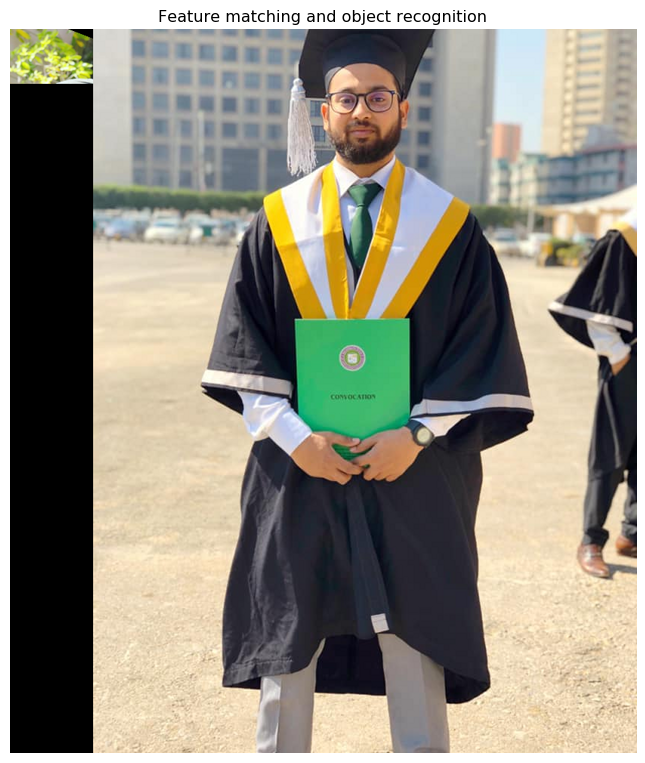

In [20]:
train_img = cv2.imread('degree.jpg')
match_feature_find_object(query_img, train_img, 10)

Not enough good matches are found - 7/10


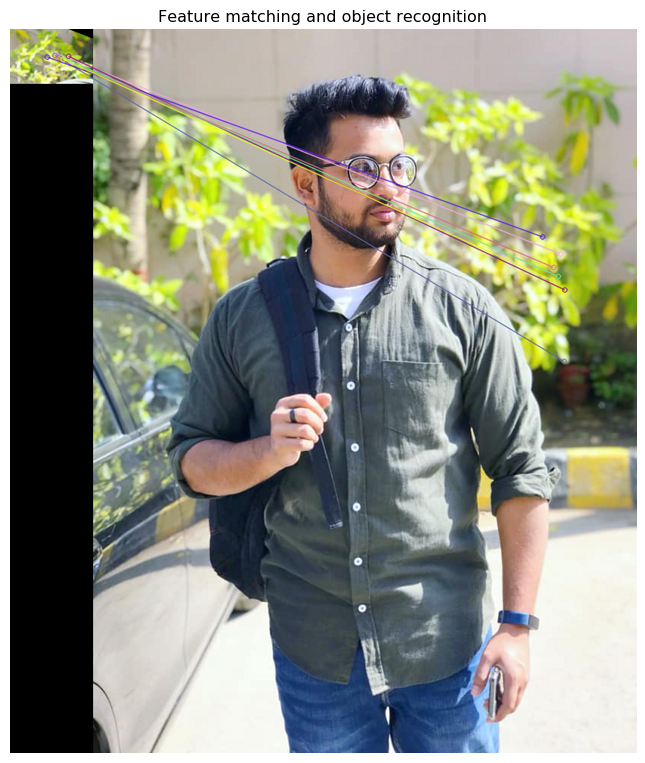

In [21]:
train_img = cv2.imread('uni.jpg')
match_feature_find_object(query_img, train_img, 10)

Not enough good matches are found - 0/10


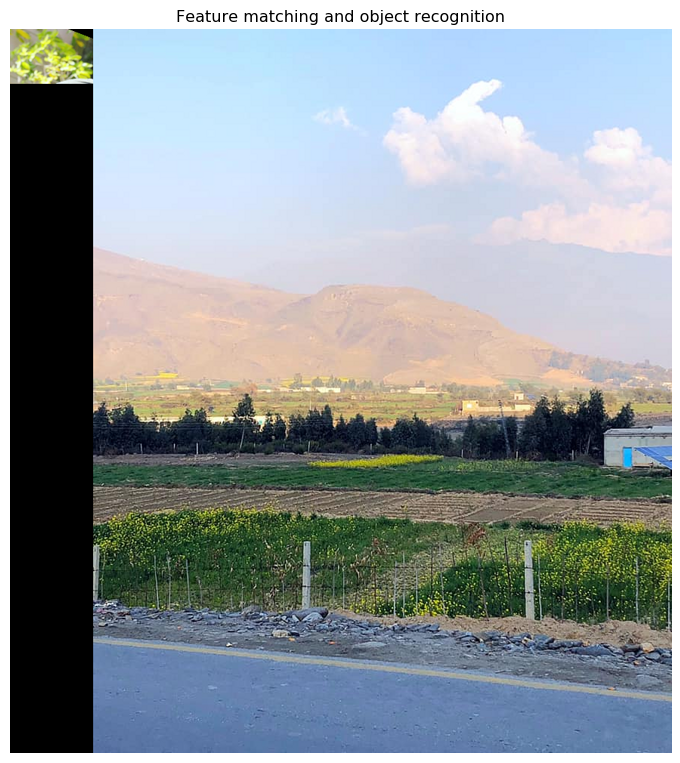

In [22]:
train_img = cv2.imread('malakand_hill.jpg')
match_feature_find_object(query_img, train_img, 10)